# shape일정 X
- MNIST
- Pictures
- numbers_data2

-> 이것을 그대로 (28 by 28) 으로 줄이게 되면 손실이 너무 많이나 upscale 하여 진행
-> VGG16을 사용하기 위해 (150 by 150) 으로 upscale 하겠다

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [2]:
# label -> to_categorical
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

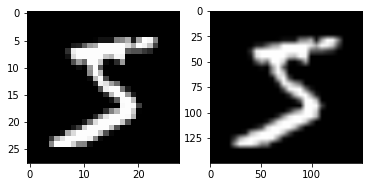

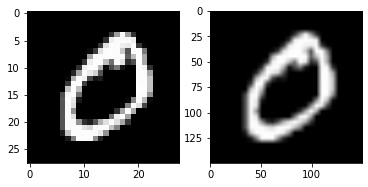

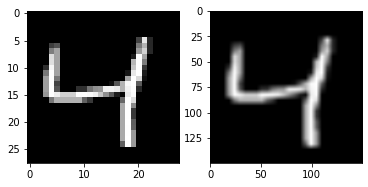

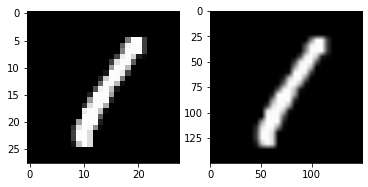

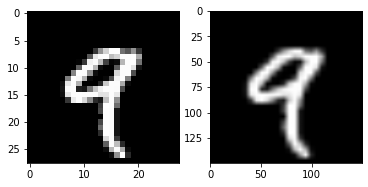

In [3]:
# (28, 28) -> (150, 150) 으로 Upscale 했을 때
for i in train_images[:5]:
    img = i
    img2 = cv2.resize(img, dsize=(150,150))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    plt.show()

In [4]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (60000, 10), (10000, 10))

In [5]:
# mnist에서 제공해주는 test data 도 train data로 학습시키기 위해 concatenate
concat_train = np.concatenate((train_images, test_images), axis=0)
concat_labels = np.concatenate((train_labels, test_labels), axis=0)
concat_train.shape, concat_labels.shape

((70000, 28, 28), (70000, 10))

In [6]:
# (150, 150) 으로 Upscale 후 저장
train_images_150 = []
for i in concat_train:
    img = i
    img2 = cv2.resize(img, dsize=(150,150))
    train_images_150.append(img2)

In [7]:
train_images_150 = np.array(train_images_150)
train_images_150.shape

(70000, 150, 150)

In [8]:
# tf.keras.preprocessing.image_dataset_from_directory를 통해 directory에서 데이터 가져오기
train_dir = 'mnist_num/train'
test_dir = 'mnist_num/test'

import tensorflow as tf
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode='categorical', color_mode='grayscale',
    image_size=(150,150), batch_size=98
)

for i, j in test_data.take(1):
    test_data_x = i
    test_data_y = j

test_data_x = np.squeeze(np.array(test_data_x))
test_data_y = np.array(test_data_y)

test_data_x.shape, test_data_y.shape

Found 98 files belonging to 10 classes.


((98, 150, 150), (98, 10))

In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='categorical', color_mode='grayscale',
    image_size=(150,150), batch_size=245
)

for i, j in train_data.take(1):
    train_data_x = i
    train_data_y = j

train_data_x = np.squeeze(np.array(train_data_x))
train_data_y = np.array(train_data_y)

train_data_x.shape, train_data_y.shape

Found 245 files belonging to 10 classes.


((245, 150, 150), (245, 10))

In [10]:
train_images_150.shape, train_data_x.shape

((70000, 150, 150), (245, 150, 150))

In [11]:
# 모든 Train data 합쳐주기
concat_train_x = np.concatenate((train_images_150, train_data_x), axis=0)
concat_train_y = np.concatenate((concat_labels, train_data_y), axis=0)

# Data Normalization
concat_train_x = concat_train_x.astype('float32') / 255
test_data_x = test_data_x.astype('float32') / 255

concat_train_x.shape, concat_train_y.shape

((70245, 150, 150), (70245, 10))

In [12]:
# Train data Shuffle
from sklearn.utils import shuffle
X, y = shuffle(concat_train_x, concat_train_y)

In [13]:
train_x = X[:60000,:,:]
train_y = y[:60000,:]
validation_x = X[60000:,:,:]
validation_y = y[60000:,:]
train_x.shape, train_y.shape, validation_x.shape, validation_y.shape

((60000, 150, 150), (60000, 10), (10245, 150, 150), (10245, 10))

In [14]:
train_x = train_x.reshape(-1, 150, 150, 1)
validation_x = validation_x.reshape(-1, 150, 150, 1)
test_data_x = test_data_x.reshape(-1, 150, 150, 1)

# VGG16..
앞서 말한 대로 VGG16을 이용해 예제와 마찬가지로 Fine Tuning으로 진행 해보려고 하였으나..  
VGG16의 경우 3채널 데이터로 학습되었기 때문에 grayscale인 mnist데이터로는 불가능하다.

-> 직접 모델을 쌓아보기로 한다.
## 모델 쌓기 Plan
VGG16의 경우 *(Conv2D 두 번, MaxPooling2D 한 번) X 2 번*   
*(Conv2D 세 번, MaxPooling2D 한 번) X 3 번*으로 되어있다

우리는 단순한 데이터이기 때문에
*(Conv2D 한 번, MaxPooling2D 한 번) X 3 번*  으로 해보려고 한다.  
--> 3 번하니 size가 너무 안줄어들어서 *(Conv2D 한 번, MaxPooling2D 한 번) X 5 번*  으로 해보았다.

In [15]:
from tensorflow.keras import models, layers

In [49]:
my_model = models.Sequential()
my_model.add(layers.Conv2D(64, (3,3), activation='relu', \
    padding='same', input_shape=(150,150,1)))
my_model.add(layers.MaxPool2D((2,2)))
my_model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
my_model.add(layers.MaxPool2D((2,2)))
my_model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
my_model.add(layers.MaxPool2D((2,2)))
my_model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
my_model.add(layers.MaxPool2D((2,2)))
my_model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
my_model.add(layers.MaxPool2D((2,2)))
my_model.add(layers.Flatten())
my_model.add(layers.Dense(512, activation='relu'))
# my_model.add(layers.Dropout(0.5))
my_model.add(layers.Dense(10, activation='softmax'))

In [50]:
my_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 150, 150, 64)      640       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 37, 37, 256)       295168    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 18, 18, 256)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 18, 18, 512)      

In [51]:
my_model.compile(optimizer='rmsprop', \
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history = my_model.fit(train_x, train_y,\
    epochs=7, batch_size=100,
    validation_data=(validation_x, validation_y))

Epoch 1/7
600/600 [==============================] - 52s 85ms/step - loss: 0.2415 - accuracy: 0.9384 - val_loss: 0.0812 - val_accuracy: 0.9765
Epoch 2/7
600/600 [==============================] - 50s 84ms/step - loss: 0.0422 - accuracy: 0.9876 - val_loss: 0.0327 - val_accuracy: 0.9906
Epoch 3/7
600/600 [==============================] - 51s 84ms/step - loss: 0.0299 - accuracy: 0.9912 - val_loss: 0.0300 - val_accuracy: 0.9919
Epoch 4/7
600/600 [==============================] - 51s 84ms/step - loss: 0.0223 - accuracy: 0.9933 - val_loss: 0.0344 - val_accuracy: 0.9907
Epoch 5/7
600/600 [==============================] - 51s 84ms/step - loss: 0.0196 - accuracy: 0.9943 - val_loss: 0.0295 - val_accuracy: 0.9930
Epoch 6/7
600/600 [==============================] - 51s 84ms/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 0.0369 - val_accuracy: 0.9930
Epoch 7/7
600/600 [==============================] - 51s 84ms/step - loss: 0.0132 - accuracy: 0.9963 - val_loss: 0.0325 - val_accuracy: 0.9931

In [52]:
my_model.save('my_model6.h5')

In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

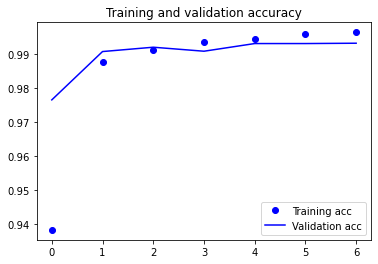

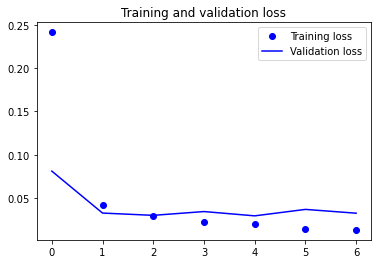

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [55]:
my_model.evaluate(test_data_x, test_data_y)

4/4 [==============================] - 0s 9ms/step - loss: 0.6764 - accuracy: 0.9388


[0.6764456033706665, 0.9387755393981934]